In [250]:
from sympy.calculus.finite_diff import finite_diff_weights
from sympy import S
import numpy as np
from scipy import sparse

In [1]:
def check_tuple(var, typ):
    if type(var)!=tuple and type(var)!=typ:
        return False 
    elif type(var)==tuple:
        if any(type(s)!=typ for s in var):
            return False
    return True

In [251]:
def diff_matrix_1d(grid_size, difference_order=4, periodic_boundary=False):
    """
    Return a differentiation matrices associated with derivative operators up to 2nd order on the line
    The derivative is calculated with respect to the equispaced grid
    The differentiation matrices are sparsed.
    
    Parameters 
    ----------
    grid_size : int nx
    difference_order : int default=4
        Controls order of the approximation of finite difference, sets the size of the stencil
        The endpoint derivatives are calculated with larger stencil for better accuracy
    peryodic_boundary: boolean, default=False
        Sets whether periodic boundary conditions are imposed
    
    Returns
    ----------
    List of differentiation matrices of size nx X nx of rising order including identity. 
    I.e. [1, dx, d2x]
    
    References
    ---------------
    Uses sympy.calculus.finite_diff.finite_diff_weights
    """
    #----------------Check input------------------ 
    if any(type(inp)!=int for inp in (grid_size, difference_order)):
        raise ValueError("grid_size and difference_order must be integers")
    if type(periodic_boundary)!=bool:
        raise ValueError("periodic_boundary must be boolean")

    if difference_order+2 > grid_size:
        raise ValueError("Stencil is larger then the whole grid")
    
    #-------------Body------------------    
    
    h0=int(difference_order/2) #This is a number of neighbours
    
    #calculate a set of derivatives with various offset and single out the central one
    #the endpoint derivatives are calculated with larger stencil for better accuracy
    weights_all=[]
    for offset in range(-h0,h0+1,1):
        if offset==0:
            stencil=[S(i) for i in range(-h0,h0+1)]
            weights_all.append(np.array(finite_diff_weights(2, stencil, offset),dtype=float)[:,-1])
        if offset<0:
            stencil=[S(i) for i in range(2*h0+2)]
            weights_all.append(np.array(finite_diff_weights(2, stencil, h0+offset),dtype=float)[:,-1])
        if offset>0:
            stencil=[S(i) for i in range(2*h0+2)]
            weights_all.append(np.array(finite_diff_weights(2, stencil, h0+1+offset),dtype=float)[:,-1])
    
    weights_center=weights_all[h0]
    
    
    #write a diff matrix of order 0 (identity) to the list
    diff_mats=[scipy.sparse.identity(grid_size)]
    
    #create the matrices for 1st and 2nd derivatives
    #non-periodic boundary
    if periodic_boundary==False:
        for deriv in range(1,3):
            #away from the boundaries the central derivatives fill the diagonal
            weights=weights_center[deriv]
            diags=np.broadcast_to(weights,(grid_size,2*h0+1)).transpose()
            in_mat=sparse.dia_matrix((diags,range(2*h0+1)),shape=(grid_size-(2*h0),grid_size)) 


            #near the bottom (beginnig of the grid) use one-sided derivatives in the left part of matrix, fill with zeros to the right
            bottom_mat_right=sparse.dia_matrix((h0,grid_size-(2*h0+2))) 
            bottom_mat_left=np.zeros((h0,2*h0+2))
            for dist in range(h0):
                bottom_mat_left[dist] = weights_all[dist][deriv]
            bottom_mat=sparse.hstack([bottom_mat_left,bottom_mat_right])

            #same near top, fill with zeros to the left
            top_mat_left=scipy.sparse.dia_matrix((h0,grid_size-(2*h0+2))) 
            top_mat_right=np.zeros((h0,2*h0+2))
            for dist in range(-h0,0):
                top_mat_right[dist] = weights_all[2*h0+1+dist][deriv]
            top_mat=sparse.hstack([top_mat_left,top_mat_right])

            full_mat=sparse.vstack([bottom_mat,in_mat,top_mat])

            diff_mats.append(full_mat)
    
    #Periodic boundary        
    if periodic_boundary==True:
        for deriv in range(1,3):
            #the central derivatives fill the diagonal plus show up in the corners
            weights=weights_center[deriv]
            diags=np.broadcast_to(weights,(grid_size,2*h0+1)).transpose()
            diags=np.vstack((diags[h0+1:],diags,diags[:h0]))
            offsets=list(range(-grid_size+1,h0+1-grid_size))+list(range(-h0,h0+1))+list(range(-h0+grid_size,grid_size))
            full_mat=sparse.dia_matrix((diags,offsets),shape=(grid_size,grid_size)) 

            diff_mats.append(full_mat)
        
    return diff_mats

In [252]:
dw=diff_matrix_1d(7,difference_order=4,periodic_boundary=False)

In [253]:
dw[2].toarray()

array([[  3.75      , -12.83333333,  17.83333333, -13.        ,
          5.08333333,  -0.83333333,   0.        ],
       [  0.83333333,  -1.25      ,  -0.33333333,   1.16666667,
         -0.5       ,   0.08333333,   0.        ],
       [ -0.08333333,   1.33333333,  -2.5       ,   1.33333333,
         -0.08333333,   0.        ,   0.        ],
       [  0.        ,  -0.08333333,   1.33333333,  -2.5       ,
          1.33333333,  -0.08333333,   0.        ],
       [  0.        ,   0.        ,  -0.08333333,   1.33333333,
         -2.5       ,   1.33333333,  -0.08333333],
       [  0.        ,   0.08333333,  -0.5       ,   1.16666667,
         -0.33333333,  -1.25      ,   0.83333333],
       [  0.        ,  -0.83333333,   5.08333333, -13.        ,
         17.83333333, -12.83333333,   3.75      ]])

In [271]:
def diff_matrix(grid_sizes, difference_orders=4, periodic_boundaries=False):
    """
    Return a differentiation matrices associated with derivative operators up to 2nd order in 1,2 or 3 dimensions.
    The derivative is calculated with respect to the equispaced multidimensional grid
    The differentiation matrices are sparsed ('csr'), obtained by Kronecker product. 
    
    Parameters 
    ----------
    ! All tuples must be the same lenght equal to the number of grid dimensions.
    
    grid_size : tuple of ints (nx,ny,...)
    difference_order : tuple of ints (int,int,...), default=(5,5)
        Controls order of the approximation of finite difference for every axis.
    periodic_boundary: tuple of booleans, default=(False,False)
        Sets whether periodic boundary conditions are imposed in given direction
    
    Returns
    ----------
    List of differentiation matrices of size (nx*ny*...)x(nx*ny*...) of rising order including identity. 
    I.e.
    in 1 dimensions
        (1,dx,dy)
    in 2 dimensions
        (1, dx, dy, d2x, d2y, dxdy)
    in 3 dimensions
        (1, dx, dy, dz, d2x, d2y, d2z, dxdy, dxdz, dydz)
    
    References
    ---------------
    Uses scipy.sparse.kron
    """
    #-----------Check input--------------
    #-----------------------------------
    def to_tuple(var):
        if type(var)!=tuple:
            return tuple([var]*len(grid_sizes))
        else:
            return var
    if not isinstance(grid_sizes,tuple): 
        raise ValueError("grid_sizes must be tuple of integers (in case of 1 dimension it can be (size,))")
    if not check_tuple(difference_orders,int):
        raise ValueError("difference_order must be integer or tuple of integers")
    if not check_tuple(periodic_boundaries,bool):
        raise ValueError("periodic_boundary must be integer or tuple of integers")
 
    (difference_orders, periodic_boundaries)=map(to_tuple, (difference_orders, periodic_boundaries))
    
    dims=tuple(len(inp) for inp in [grid_sizes, difference_orders, periodic_boundaries])
    if any(s1!=s2 for s1, s2 in zip(dims,dims[1:])):
        raise ValueError("Dimensions of grid, order and periodicity flags must be equal.")
    if dims[0]>3:
        raise ValueError("Only 1,2 or 3 dimensional grids are currently supported")

    
    #-------Body-----------------------
    #-----------------------------------
    
    axes_diff_mats=[]
    for i, size in enumerate(grid_sizes):
        mat=diff_matrix_1d(grid_sizes[i], difference_orders[i], periodic_boundaries[i])
        axes_diff_mats.append(mat)
    
    #define in what sequence the diff matrices are returned
    if dims[0]==1:
        derivative_sequence=((0,),(1,),(2,))
    elif dims[0]==2:
        derivative_sequence=((0,0),(1,0),(0,1),(2,0),(0,2),(1,1))
    elif dims[0]==3:
        derivative_sequence=((0,0,0),(1,0,0),(0,1,0),(0,0,1),(2,0,0),(0,2,0),(0,0,2),(1,1,0),(1,0,1),(0,1,1))

    #produce kronecker products
    diff_mats=[]
    for d, deriv in enumerate(derivative_sequence):
        mat=axes_diff_mats[0][deriv[0]]
        for axis in range(1,dims[0]):
            mat_axis=axes_diff_mats[axis][deriv[axis]]
            mat=sparse.kron(mat,mat_axis,"csr")
        diff_mats.append(mat)
    
    return diff_mats

In [335]:
t1=diff_matrix((6,6),4,False)

In [336]:
t1[1].shape

(36, 36)

In [321]:
import matplotlib.pyplot as plt
%matplotlib inline

In [305]:
t1[1].toarray();

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


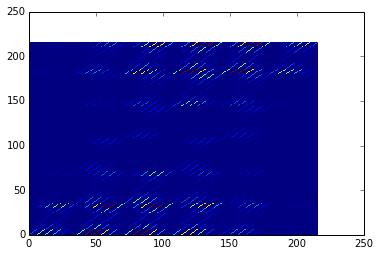

In [324]:
plt.pcolor(abs(t1[7].toarray()))

In [325]:
from sys import getsizeof

In [337]:
getsizeof(t1)

128